# Tutorial 2: Conditional Adversarial Network (CGAN)
## Generating visible from infra-red satellite images

**Authors:** Paula Bigalke, Claudia Acquistapace, Daniele Corradini

**Affiliation:** Institute of Geophysics and Meteorology, University of Cologne, Germany

**Contact**: paula.bigalke@uni-koeln.de, cacquist@uni-koeln.de, dcorrad1@uni-koeln.de

## 2.2 - Setting up the model (x / y points)

In a next step the models' architectures need to be defined. The generator is the part of the network that tries to generate a "fake" visible (VIS) image from the given infra-red (IR) image. The discriminator then will evaluate if a given image is "real" or "fake". They both try to improve their skills to win this battle. In this exercise, you will investigate how the models are build in tensorflow.

#### Installing packages

As always, we start by installing some packages. If you run the notebook on your personal computer, you only need to install them once. In Google Colab, however, you need to install them again each time you open the notebook.

In [ ]:
# Install packages in Google Colab
# !pip install satpy matplotlib cartopy

#In Google Colab, you use a pre-configured environment that runs in the cloud,
#but you can still install packages during your session. However, note that these installations are temporary;
#they only last for the duration of your session.
#Once the session ends, you'll need to reinstall any packages when you start a new session.

### Import Libraries

In [2]:
import os
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.utils import plot_model

2024-05-30 22:07:46.339267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Access permission to Google Drive & setting folder path

In [3]:
##### TODO ###########################################################################################################
##### give authorization to access your Google Drive in pop-up window that opens with this code

#drivedir='/content/drive'
#drive.mount(drivedir)
#os.chdir(drivedir)

##### TODO ###########################################################################################################
##### define path to tutorial directory

TUTORIAL_DIR = "/net/merisi/pbigalke/teaching/METFUT2024/CGAN_Pix2Pix_MSG/" ### /My Drive/.../ end path with /

# check if this path exists (if you have filled in the correct loaction). 
# If it gives you "False" then there was a mistake in the path
os.path.exists(TUTORIAL_DIR)

True

### Pre-define layers

First, we define some convolutional layers that both the generator and discriminator use. Downsample reduces the input size while increasing the number of filters. Upsample does the opposite - increasing the input size and reducing the number of filters.

In [4]:
# downsample block
def _downsample(filters, size, batchnorm=True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding="same", 
                      kernel_initializer=init, use_bias=False))
    if batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result

# upsample block
def _upsample(filters, size, dropout=False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding="same", 
                               kernel_initializer=init, use_bias=False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

### (a) The Generator (1 p)

Let's start with the generator. It consists of an encoder and a decoder part, each made of several convolutional layers. First, the encoder downsamples the input (IR image) to a 1D representation vector extracting features from the IR image. Then, starting from the representation vector, the decoder upsamples it again to the original size generating a fake VIS image. By adding skip connections, the extracted information of each encoder layer is given to the respective decoder layer as additional input. This greatly improves the performance of generating images.

**Task a.1** (1 p): In the following the generator model is defined. Find out where the different layers are created and print after each layer the shape of its output x.

In [5]:
# definition of generator (complete architecture)
def generator(image_size=128, image_channels=1, kernel_size=4):
    
    # -------------------------------- Define type of layers that will be used -----------------------------------    
    # define input layer
    inputs = Input(shape = [image_size, image_size, image_channels])
    # define all downsample layers
    down_stack = [
        _downsample(64, kernel_size, batchnorm=False),
        _downsample(128, kernel_size),
        _downsample(256, kernel_size),
        _downsample(512, kernel_size),
        _downsample(512, kernel_size),
        _downsample(512, kernel_size),
        _downsample(512, kernel_size), 
    ]
    
    # define all upsample layers
    up_stack = [
        _upsample(512, kernel_size, dropout=True),
        _upsample(512, kernel_size, dropout=True),
        _upsample(512, kernel_size),
        _upsample(256, kernel_size),  
        _upsample(128, kernel_size), 
        _upsample(64, kernel_size), 
    ]
    # define last output layer
    last = Conv2DTranspose(image_channels, kernel_size, strides=2, padding="same", 
                           kernel_initializer=tf.random_normal_initializer(0., 0.02), 
                           activation="tanh")
    

    # ------------ Create layers in correct order, each taking the output x of the previous layer as input -----------------    

    # input x to network
    x = inputs
    print("input layer: ", x.shape)

    ##### TODO ###########################################################################################################
    ##### in the following: print the shape of the output x after each layer
    
    # loop over downsample layers
    skips = []
    for down in down_stack:
        # call downsample layer on input x
        x = down(x)
        print("downsample layer: ", x.shape)
        
        # save this output for later creating the skip connections
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # loop over upsample layers
    for up, skip in zip(up_stack, skips):
        # call upsample layer on input x
        x = up(x)
        print("upsample layer: ", x.shape)

        # add skip connection to output x of this layer
        x = Concatenate()([x, skip])
        print("up + skip layer: ", x.shape)
    
    # call last layer
    x = last(x)
    print("last layer: ", x.shape)

    # return model
    return Model(inputs=inputs, outputs=x)


# create a generator model
gen_model = generator()

input layer:  (None, 128, 128, 1)
downsample layer:  (None, 64, 64, 64)
downsample layer:  (None, 32, 32, 128)
downsample layer:  (None, 16, 16, 256)
downsample layer:  (None, 8, 8, 512)
downsample layer:  (None, 4, 4, 512)
downsample layer:  (None, 2, 2, 512)
downsample layer:  (None, 1, 1, 512)
upsample layer:  (None, 2, 2, 512)
up + skip layer:  (None, 2, 2, 1024)
upsample layer:  (None, 4, 4, 512)
up + skip layer:  (None, 4, 4, 1024)
upsample layer:  (None, 8, 8, 512)
up + skip layer:  (None, 8, 8, 1024)
upsample layer:  (None, 16, 16, 256)
up + skip layer:  (None, 16, 16, 512)
upsample layer:  (None, 32, 32, 128)
up + skip layer:  (None, 32, 32, 256)
upsample layer:  (None, 64, 64, 64)
up + skip layer:  (None, 64, 64, 128)
last layer:  (None, 128, 128, 1)


To check if you have spotted all the different layers correctly in the code, you can print a summary of the model and also create an overview plot with tensorflow. 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 64)           1024      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

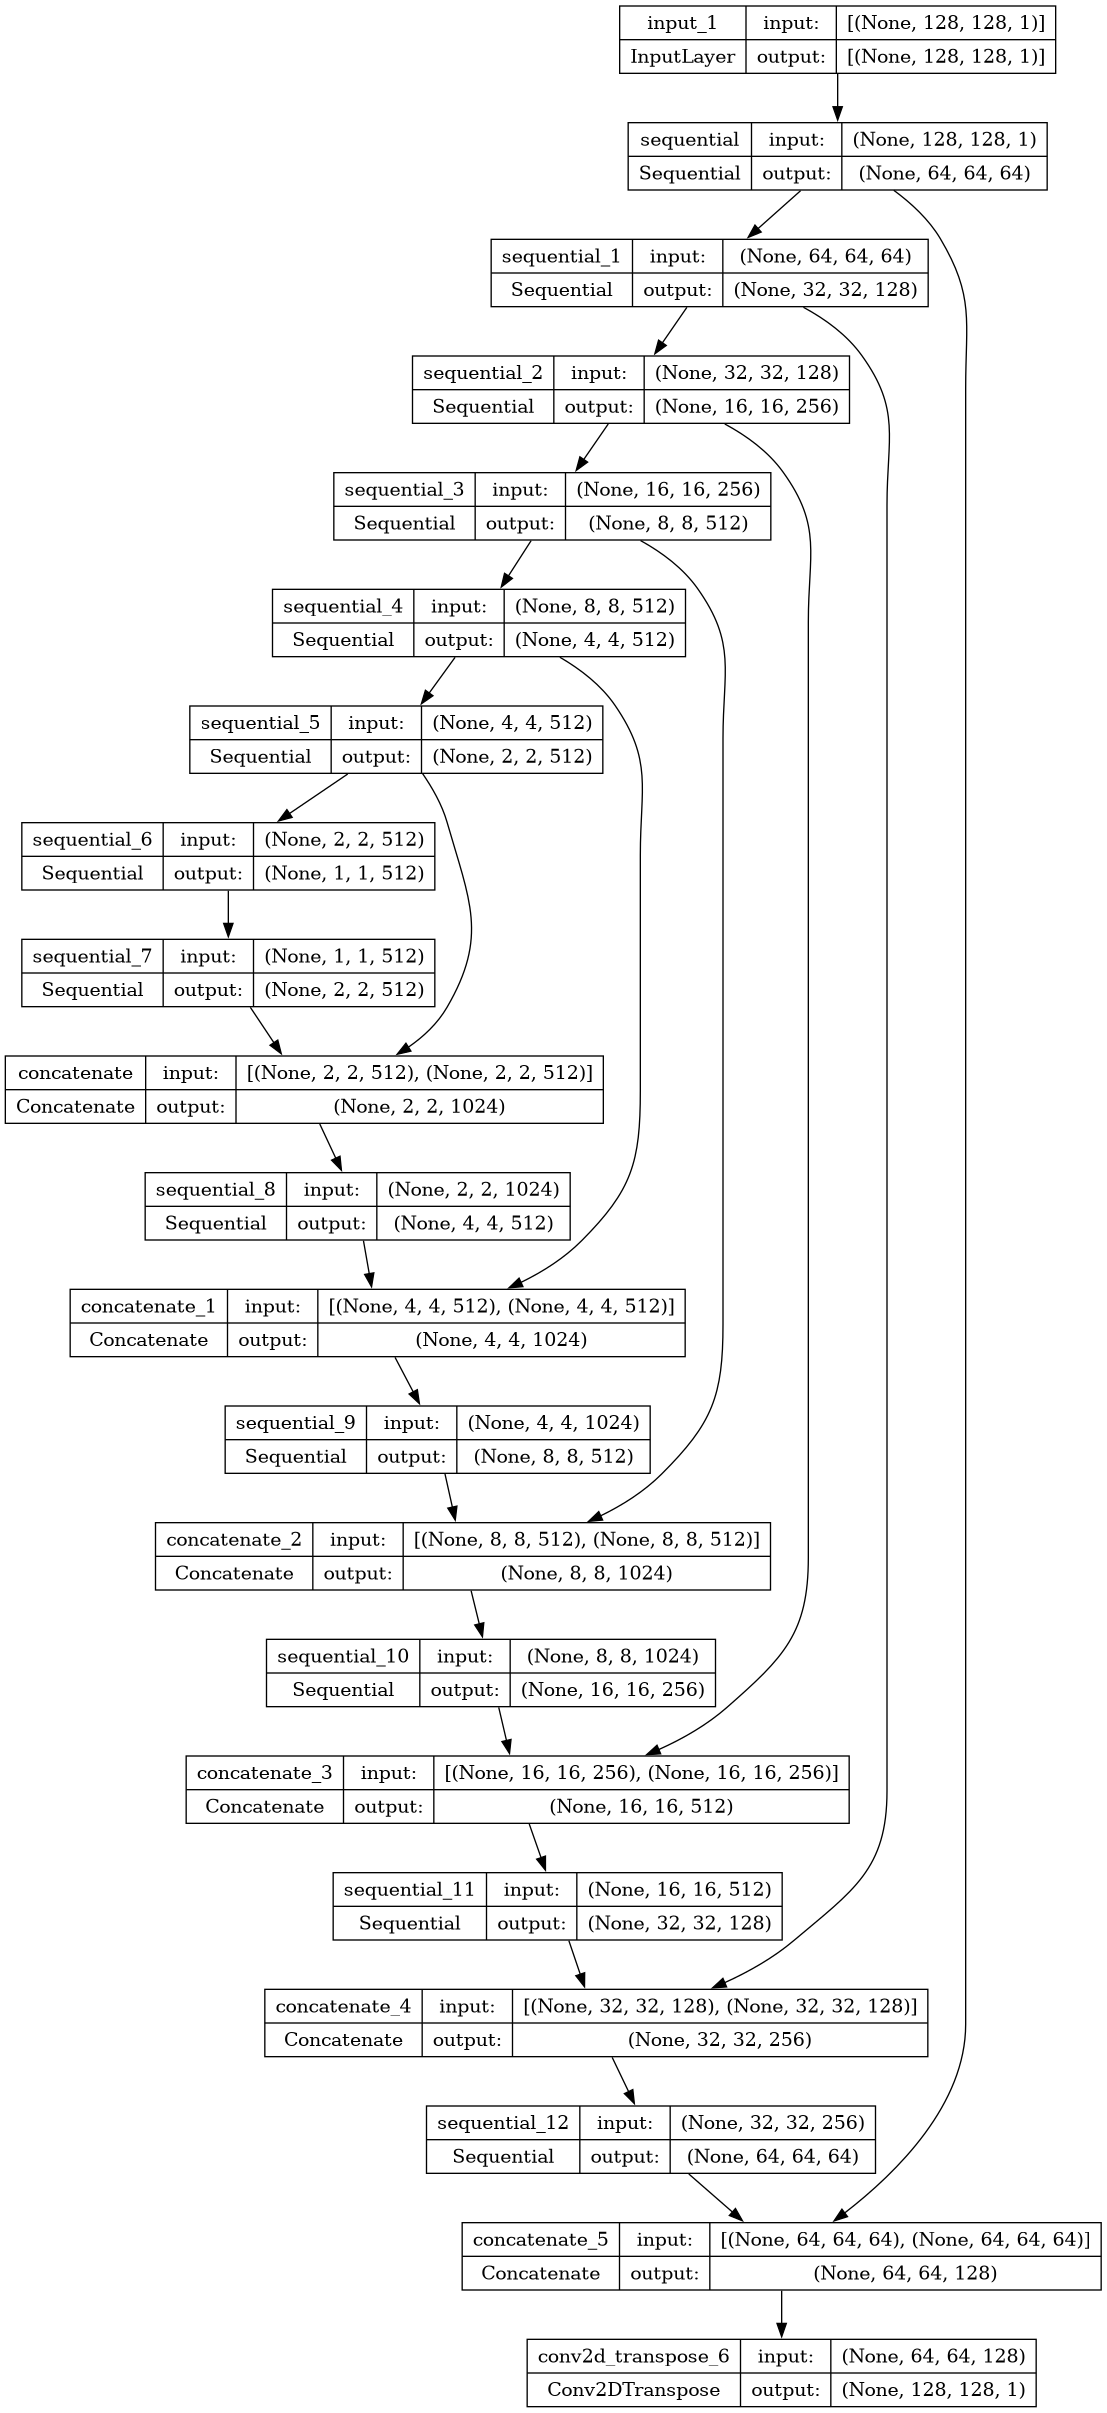

In [7]:
# print summary of generator model
gen_model.summary()

# create output folder if is doesn't exist
if not os.path.exists(TUTORIAL_DIR + "output/model/"):
    os.makedirs(TUTORIAL_DIR + "output/model/")

# plot overview of generator model and save to output folder
gen_overview = TUTORIAL_DIR + "output/model/architecture_generator.png"
plot_model(gen_model,  to_file=gen_overview, show_shapes=True)

### (b) The Discriminator (1 p)

Now coming to the discriminator. Its architecture is a bit simpler, consisting of a set of convolutional layers. Taking the IR image **and** a VIS image (real or fake) as input. It samples down to a 1D vector representation. During training the network learns to map **real** VIS images onto vectors close to (1, 1, ..., 1) and **fake** VIS images close to (0, 0, ..., 0).

**Task b.1** (1 p): Create a discriminator model and print its summary. Save an overview plot to the output/model/ folder.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ir_image (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 vis_image (real or fake) (  [(None, 128, 128, 1)]        0         []                            
 InputLayer)                                                                                      
                                                                                                  
 concatenate_6 (Concatenate  (None, 128, 128, 2)          0         ['ir_image[0][0]',            
 )                                                                   'vis_image (real or fake)[0][
                                                                    0]']                    

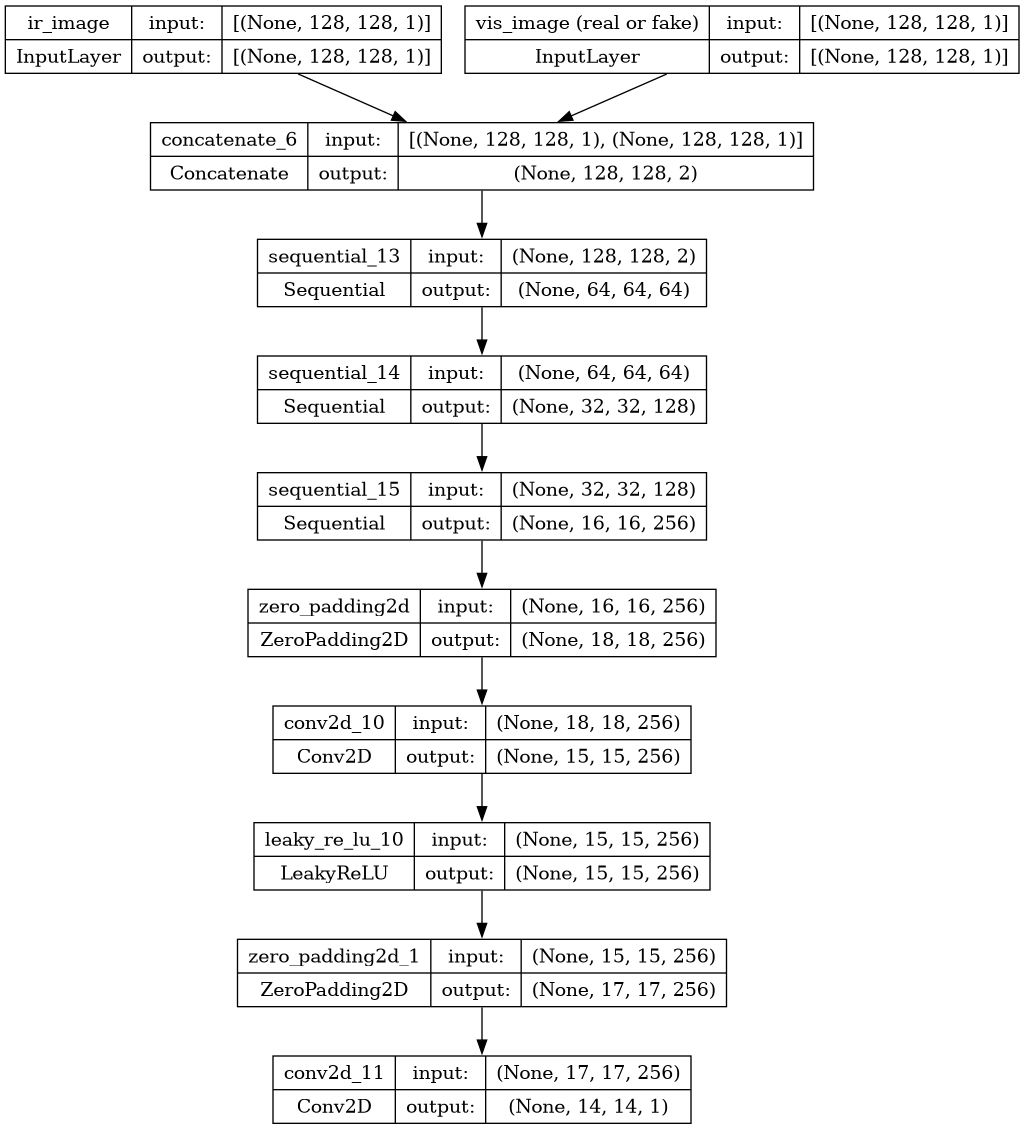

In [8]:
# definition of discriminator (complete architecture)
def discriminator(image_size=128, image_channels=1, kernel_size=4):
    init = tf.random_normal_initializer(0., 0.02)
    

    inp = Input(shape = [image_size, image_size, image_channels], name="ir_image")
    tar = Input(shape = [image_size, image_size, image_channels], name="vis_image (real or fake)")
    x = Concatenate()([inp, tar])

    down1 = _downsample(64, kernel_size, batchnorm=False)(x)
    down2 = _downsample(128, kernel_size)(down1)
    down3 = _downsample(256, kernel_size)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, kernel_size, strides=1, 
                  kernel_initializer=init, 
                  use_bias=False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)

    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, kernel_size, strides=1, 
                  kernel_initializer=init)(zero_pad2)

    return Model(inputs=[inp, tar], outputs=last)


##### TODO ###########################################################################################################
##### create a discriminator model, print a summary and save an overview plot of the discriminator model

# create a discriminator model
#discr_model = ...  # TODO

# print summary of discriminator model
#...  # TODO

# plot overview of discriminator model
discr_overview = TUTORIAL_DIR + "output/model/architecture_discriminator.png"
#...  # TODO

# <<<<<< Solution
# create a discriminator model
discr_model = discriminator()

# print summary of discriminator model
discr_model.summary()

# plot overview of discriminator model
discr_overview = TUTORIAL_DIR + "output/model/architecture_discriminator.png"
plot_model(discr_model, to_file=discr_overview, show_shapes=True)
